In [1]:
# Setup: imports and paths
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

pd.set_option('display.max_columns', 120)
sns.set_theme(style='whitegrid')

DATA_DIR = os.path.join(os.getcwd(), 'datasets')
assert os.path.isdir(DATA_DIR), f"Missing datasets dir: {DATA_DIR}"
print('PyTorch:', torch.__version__)
print('Data dir:', DATA_DIR)


PyTorch: 2.8.0+cpu
Data dir: /app/datasets


In [2]:
# Config
LABEL_COL = 'Label'            # set the label column explicitly
NROWS_PER_CSV = 100_000        # sample per CSV for speed
BATCH_SIZE = 512               # larger batches for MPS
EPOCHS = 3                     # training epochs
LOG_INTERVAL = 50              # batches between logs
MAX_BATCHES = None             # cap batches per epoch (None means all)
SEED = 42

import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [3]:
# Load a sample of CSVs and combine
csv_paths = sorted(glob.glob(os.path.join(DATA_DIR, '*.csv')))
assert csv_paths, 'No CSVs found in datasets/'
print('Found CSVs:', len(csv_paths))

# Read a subset for speed
frames = []
for p in csv_paths:
    try:
        df = pd.read_csv(p, nrows=NROWS_PER_CSV)
        df['__source__'] = os.path.basename(p)
        frames.append(df)
        print('Loaded', os.path.basename(p), df.shape)
    except Exception as e:
        print('Skip', os.path.basename(p), e)

data = pd.concat(frames, ignore_index=True)
print('Combined shape:', data.shape)

data.head()


Found CSVs: 8
Loaded Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv (100000, 80)
Loaded Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv (100000, 80)
Loaded Friday-WorkingHours-Morning.pcap_ISCX.csv (100000, 80)
Loaded Monday-WorkingHours.pcap_ISCX.csv (100000, 80)
Loaded Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv (100000, 80)
Loaded Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv (100000, 80)
Loaded Tuesday-WorkingHours.pcap_ISCX.csv (100000, 80)
Loaded Wednesday-workingHours.pcap_ISCX.csv (100000, 80)
Combined shape: (800000, 80)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,__source__
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv


Normalized column names (stripped whitespace).
Missing ratio (top 20):
Flow Bytes/s            0.000231
Destination Port        0.000000
Bwd Avg Packets/Bulk    0.000000
Fwd Avg Bulk Rate       0.000000
Fwd Avg Packets/Bulk    0.000000
Fwd Avg Bytes/Bulk      0.000000
Fwd Header Length.1     0.000000
Avg Bwd Segment Size    0.000000
Avg Fwd Segment Size    0.000000
Average Packet Size     0.000000
Down/Up Ratio           0.000000
ECE Flag Count          0.000000
CWE Flag Count          0.000000
URG Flag Count          0.000000
ACK Flag Count          0.000000
PSH Flag Count          0.000000
RST Flag Count          0.000000
SYN Flag Count          0.000000
FIN Flag Count          0.000000
Bwd Avg Bytes/Bulk      0.000000
dtype: float64
Label candidates: ['Label']


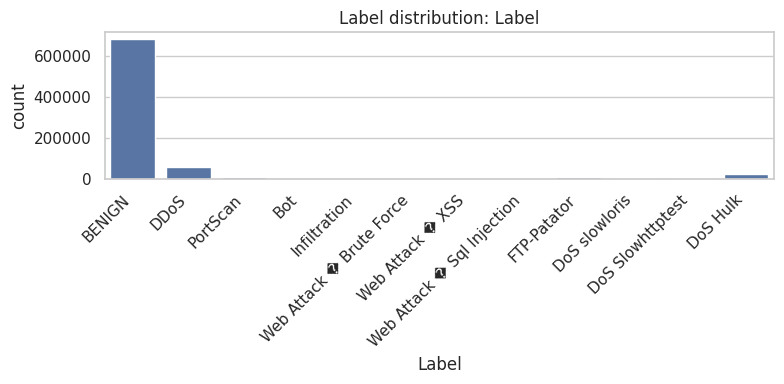

In [4]:
# Basic EDA: missing values and label distribution
# Normalize column names first
orig_cols = list(data.columns)
data.columns = [str(c).strip() for c in data.columns]
if orig_cols != list(data.columns):
    print('Normalized column names (stripped whitespace).')

missing = data.isna().mean().sort_values(ascending=False)
print('Missing ratio (top 20):')
print(missing.head(20))

# Use explicit label if present, otherwise try to infer
label_col = LABEL_COL if LABEL_COL in data.columns else None
if label_col is None:
    label_candidates = [c for c in data.columns if c.lower() in ['label','attack','class','target','outcome']]
else:
    label_candidates = [label_col]
print('Label candidates:', label_candidates)

if label_candidates:
    label_col = label_candidates[0]
    plt.figure(figsize=(8,4))
    sns.countplot(data=data, x=label_col)
    plt.title(f'Label distribution: {label_col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print('No obvious label column found.')


Numeric features: 78
Extreme values check:
Min: -3.2212234e+10 Max: inf
Any inf? True
Any extremely large? True
Feature ranges after robust scaling:
Min: -228.97351 Max: 316.22598
X shape: (800000, 78) num_classes: 12


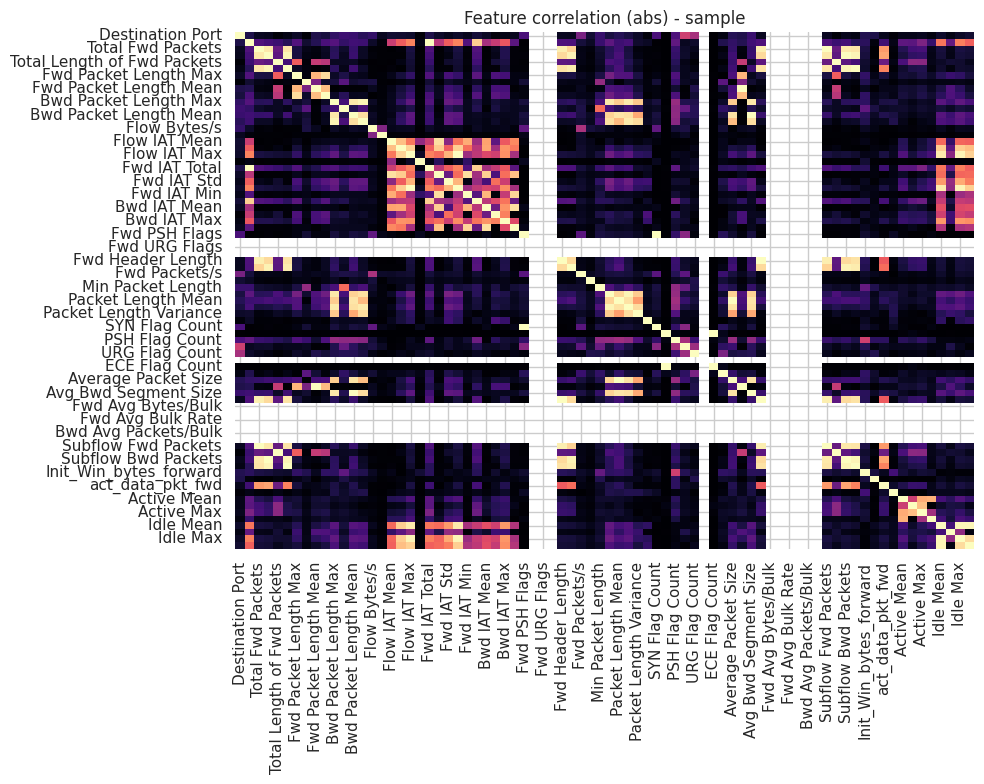

In [5]:
# Feature selection: numeric columns only
num_cols = [c for c in data.columns if np.issubdtype(data[c].dtype, np.number)]
print('Numeric features:', len(num_cols))

# Drop columns with too many missing values
keep_cols = [c for c in num_cols if data[c].isna().mean() < 0.2]
X_raw = data[keep_cols].fillna(0.0).astype(np.float32)

# Check for extreme values (same as before)
print('Extreme values check:')
print('Min:', X_raw.min().min(), 'Max:', X_raw.max().max())
print('Any inf?', np.isinf(X_raw.values).any())
print('Any extremely large?', (np.abs(X_raw.values) > 1e10).any())

#clip extreme values
X_clipped = X_raw.clip(-1e8, 1e8)

# SIMPLE STANDARD NORMALIZATION (Z-score)
X_mean = X_clipped.mean()         
X_std = X_clipped.std()            
X_std = X_std.replace(0, 1)     

# Standard Z-score normalization: (x - mean) / std
X = (X_clipped - X_mean) / X_std
print('Feature ranges after robust scaling:')
print('Min:', X.min().min(), 'Max:', X.max().max())

# Build supervised targets from explicit label
y_categorical = data[LABEL_COL].astype('category')
y = y_categorical.cat.codes.values.astype(np.int64)
num_classes = int(y_categorical.cat.categories.size)

print('X shape:', X.shape, 'num_classes:', num_classes)

# Quick correlation heatmap on a small subset
corr_sample = X.sample(min(len(X), 5000), random_state=42)
plt.figure(figsize=(10,8))
sns.heatmap(corr_sample.corr().abs().clip(0,1), cmap='magma', cbar=False)
plt.title('Feature correlation (abs) - sample')
plt.tight_layout()
plt.show()

In [6]:
# Minimal PyTorch dataset and model
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

features = torch.from_numpy(X.values)
targets = torch.from_numpy(y)
dataset = TensorDataset(features, targets)

# Three-way split: Train/Val/Test (60/20/20)
test_size = int(0.2 * len(dataset))
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(
    dataset, 
    [train_size, val_size, test_size], 
    generator=torch.Generator().manual_seed(42)
)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

print(f"Dataset splits - Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

class MLP(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        hidden = max(32, min(512, in_dim * 2))
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.BatchNorm1d(hidden),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.BatchNorm1d(hidden),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(features.shape[1], num_classes)

# Device selection optimized for Docker environments
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using CUDA: {torch.cuda.get_device_name()}')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Apple Silicon MPS')
else:
    device = torch.device('cpu')
    torch.set_num_threads(torch.get_num_threads())
    print(f'Using CPU: {torch.get_num_threads()} threads')

model.to(device)

# Choose loss based on task shape
if num_classes > 1:
    criterion = nn.CrossEntropyLoss()
else:
    # For 1-class fallback, treat as regression placeholder
    criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print(model)
print('Using device:', device)

Dataset splits - Train: 480000, Val: 160000, Test: 160000
Using CPU: 8 threads
MLP(
  (net): Sequential(
    (0): Linear(in_features=78, out_features=156, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=156, out_features=156, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=156, out_features=12, bias=True)
  )
)
Using device: cpu


In [7]:
# Training loop (few epochs) with robust dtypes and tqdm fallback
try:
    from tqdm import tqdm  # avoids ipywidgets renderer
except Exception:  # pragma: no cover
    def tqdm(x, **kwargs):
        return x

def accuracy(logits, targets):
    if logits.ndim == 1 or logits.shape[1] == 1:
        return float('nan')
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

def compute_loss(outputs, targets):
    if num_classes > 1:
        return criterion(outputs, targets.long())
    else:
        return criterion(outputs.squeeze().float(), targets.float())

EPOCHS = EPOCHS  # from config
import time

history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}


for epoch in range(1, EPOCHS+1):
    start_epoch = time.time()
    model.train()
    print("Model: ", model)
    print("---------------------")

    train_loss = 0.0
    train_acc = 0.0
    num_train = 0
    for b_idx, (xb, yb) in enumerate(tqdm(train_dl, leave=False)):
        if MAX_BATCHES and b_idx >= MAX_BATCHES:
            break
        t0 = time.time()
        xb = xb.to(device).float()
        # print("xb: ", xb)
        yb = yb.to(device)
        # print("YB: ", yb)
        optimizer.zero_grad()
        out = model(xb)
        # print("Out: ", out)
        loss = compute_loss(out, yb)
        # print("Loss: ", loss)
        loss.backward()
        optimizer.step()
        batch_time = time.time() - t0
        num_train += xb.size(0)
        train_loss += loss.item() * xb.size(0)
        if num_classes > 1:
            train_acc += accuracy(out, yb) * xb.size(0)
        if (b_idx + 1) % LOG_INTERVAL == 0:
            speed = xb.size(0) / batch_time if batch_time > 0 else float('inf')
            print(f"Epoch {epoch} | Batch {b_idx+1} | loss={loss.item():.4f} | {speed:.1f} samples/s | seen={num_train}")
    train_loss /= max(1, num_train)
    print("Train Loss:", train_loss)
    train_acc = (train_acc / max(1, num_train)) if num_classes > 1 else float('nan')

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    num_val = 0
    with torch.no_grad():
        for b_idx, (xb, yb) in enumerate(val_dl):
            if MAX_BATCHES and b_idx >= MAX_BATCHES:
                break
            xb = xb.to(device).float()
            yb = yb.to(device)
            out = model(xb)
            loss = compute_loss(out, yb)
            val_loss += loss.item() * xb.size(0)
            num_val += xb.size(0)
            if num_classes > 1:
                val_acc += accuracy(out, yb) * xb.size(0)
    val_loss /= max(1, num_val)
    val_acc = (val_acc / max(1, num_val)) if num_classes > 1 else float('nan')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    epoch_time = time.time() - start_epoch
    print(f"Epoch {epoch} done in {epoch_time:.1f}s | train_loss={train_loss:.4f} val_loss={val_loss:.4f} train_acc={train_acc:.4f} val_acc={val_acc:.4f}")


Model:  MLP(
  (net): Sequential(
    (0): Linear(in_features=78, out_features=156, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=156, out_features=156, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=156, out_features=12, bias=True)
  )
)
---------------------


  7%|▋         | 68/938 [00:00<00:05, 152.53it/s]

Epoch 1 | Batch 50 | loss=0.3166 | 182392.0 samples/s | seen=25600


 13%|█▎        | 120/938 [00:00<00:04, 167.72it/s]

Epoch 1 | Batch 100 | loss=0.1332 | 135573.5 samples/s | seen=51200


 18%|█▊        | 171/938 [00:01<00:04, 155.24it/s]

Epoch 1 | Batch 150 | loss=0.0850 | 148645.6 samples/s | seen=76800


 24%|██▍       | 224/938 [00:01<00:04, 159.98it/s]

Epoch 1 | Batch 200 | loss=0.0979 | 137298.4 samples/s | seen=102400


 29%|██▉       | 271/938 [00:01<00:04, 141.92it/s]

Epoch 1 | Batch 250 | loss=0.0794 | 106027.6 samples/s | seen=128000


 34%|███▎      | 315/938 [00:02<00:05, 124.54it/s]

Epoch 1 | Batch 300 | loss=0.0477 | 123496.7 samples/s | seen=153600


 38%|███▊      | 352/938 [00:02<00:07, 79.89it/s] 

Epoch 1 | Batch 350 | loss=0.0452 | 34784.9 samples/s | seen=179200


 43%|████▎     | 408/938 [00:03<00:09, 56.97it/s]

Epoch 1 | Batch 400 | loss=0.0528 | 27852.5 samples/s | seen=204800


 51%|█████     | 476/938 [00:04<00:04, 96.78it/s]

Epoch 1 | Batch 450 | loss=0.0681 | 131529.6 samples/s | seen=230400


 54%|█████▎    | 503/938 [00:04<00:03, 109.73it/s]

Epoch 1 | Batch 500 | loss=0.0753 | 92044.2 samples/s | seen=256000


 59%|█████▉    | 557/938 [00:05<00:05, 65.91it/s] 

Epoch 1 | Batch 550 | loss=0.0429 | 36627.7 samples/s | seen=281600


 66%|██████▌   | 615/938 [00:06<00:03, 106.34it/s]

Epoch 1 | Batch 600 | loss=0.0230 | 131860.7 samples/s | seen=307200


 70%|███████   | 659/938 [00:06<00:02, 103.48it/s]

Epoch 1 | Batch 650 | loss=0.0363 | 39579.1 samples/s | seen=332800


 75%|███████▌  | 707/938 [00:07<00:03, 70.70it/s] 

Epoch 1 | Batch 700 | loss=0.0375 | 38464.0 samples/s | seen=358400


 81%|████████  | 762/938 [00:08<00:01, 90.02it/s] 

Epoch 1 | Batch 750 | loss=0.0437 | 118730.8 samples/s | seen=384000


 87%|████████▋ | 813/938 [00:08<00:01, 69.31it/s]

Epoch 1 | Batch 800 | loss=0.0876 | 35142.4 samples/s | seen=409600


 93%|█████████▎| 872/938 [00:09<00:00, 95.54it/s]

Epoch 1 | Batch 850 | loss=0.0739 | 114924.7 samples/s | seen=435200


 97%|█████████▋| 914/938 [00:10<00:00, 115.20it/s]

Epoch 1 | Batch 900 | loss=0.0239 | 64624.8 samples/s | seen=460800


Train Loss: 0.12255127122104167
Epoch 1 done in 11.4s | train_loss=0.1226 val_loss=0.0354 train_acc=0.9750 val_acc=0.9905
Model:  MLP(
  (net): Sequential(
    (0): Linear(in_features=78, out_features=156, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=156, out_features=156, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=156, out_features=12, bias=True)
  )
)
---------------------


  8%|▊         | 76/938 [00:00<00:05, 148.51it/s]

Epoch 2 | Batch 50 | loss=0.0401 | 182283.6 samples/s | seen=25600


 13%|█▎        | 121/938 [00:00<00:05, 141.86it/s]

Epoch 2 | Batch 100 | loss=0.0238 | 142585.7 samples/s | seen=51200


 17%|█▋        | 164/938 [00:01<00:06, 128.14it/s]

Epoch 2 | Batch 150 | loss=0.0282 | 239701.3 samples/s | seen=76800


 22%|██▏       | 208/938 [00:01<00:06, 115.26it/s]

Epoch 2 | Batch 200 | loss=0.0261 | 143089.3 samples/s | seen=102400


 29%|██▊       | 269/938 [00:02<00:05, 133.19it/s]

Epoch 2 | Batch 250 | loss=0.0290 | 165114.8 samples/s | seen=128000


 35%|███▍      | 324/938 [00:02<00:03, 162.86it/s]

Epoch 2 | Batch 300 | loss=0.0203 | 210640.9 samples/s | seen=153600


 40%|███▉      | 371/938 [00:02<00:05, 102.73it/s]

Epoch 2 | Batch 350 | loss=0.0251 | 30789.2 samples/s | seen=179200


 45%|████▍     | 422/938 [00:03<00:03, 138.62it/s]

Epoch 2 | Batch 400 | loss=0.0371 | 101713.8 samples/s | seen=204800


 52%|█████▏    | 485/938 [00:03<00:02, 178.59it/s]

Epoch 2 | Batch 450 | loss=0.0306 | 253599.9 samples/s | seen=230400


 56%|█████▌    | 526/938 [00:03<00:02, 188.59it/s]

Epoch 2 | Batch 500 | loss=0.0233 | 105387.6 samples/s | seen=256000


 63%|██████▎   | 592/938 [00:04<00:01, 204.39it/s]

Epoch 2 | Batch 550 | loss=0.0327 | 214641.0 samples/s | seen=281600


 68%|██████▊   | 635/938 [00:04<00:01, 208.17it/s]

Epoch 2 | Batch 600 | loss=0.0284 | 190009.2 samples/s | seen=307200


 72%|███████▏  | 677/938 [00:04<00:01, 202.79it/s]

Epoch 2 | Batch 650 | loss=0.0217 | 216022.9 samples/s | seen=332800


 79%|███████▉  | 742/938 [00:04<00:00, 206.81it/s]

Epoch 2 | Batch 700 | loss=0.0207 | 197560.6 samples/s | seen=358400


 83%|████████▎ | 783/938 [00:05<00:00, 188.25it/s]

Epoch 2 | Batch 750 | loss=0.0261 | 231409.9 samples/s | seen=384000


 88%|████████▊ | 824/938 [00:05<00:00, 193.25it/s]

Epoch 2 | Batch 800 | loss=0.0272 | 184539.3 samples/s | seen=409600


 92%|█████████▏| 867/938 [00:05<00:00, 200.53it/s]

Epoch 2 | Batch 850 | loss=0.0470 | 248292.7 samples/s | seen=435200


 99%|█████████▉| 930/938 [00:05<00:00, 180.90it/s]

Epoch 2 | Batch 900 | loss=0.0118 | 231185.7 samples/s | seen=460800


Train Loss: 0.03535061246057351
Epoch 2 done in 6.8s | train_loss=0.0354 val_loss=0.0301 train_acc=0.9898 val_acc=0.9913
Model:  MLP(
  (net): Sequential(
    (0): Linear(in_features=78, out_features=156, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=156, out_features=156, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=156, out_features=12, bias=True)
  )
)
---------------------


  9%|▉         | 86/938 [00:00<00:04, 204.08it/s]

Epoch 3 | Batch 50 | loss=0.0430 | 242434.4 samples/s | seen=25600


 14%|█▎        | 128/938 [00:00<00:03, 205.08it/s]

Epoch 3 | Batch 100 | loss=0.0250 | 182361.0 samples/s | seen=51200


 18%|█▊        | 169/938 [00:00<00:04, 174.50it/s]

Epoch 3 | Batch 150 | loss=0.0612 | 108760.9 samples/s | seen=76800


 24%|██▍       | 224/938 [00:01<00:04, 167.43it/s]

Epoch 3 | Batch 200 | loss=0.0263 | 200082.3 samples/s | seen=102400


 28%|██▊       | 265/938 [00:01<00:03, 179.82it/s]

Epoch 3 | Batch 250 | loss=0.0116 | 248551.3 samples/s | seen=128000


 34%|███▍      | 319/938 [00:01<00:03, 158.11it/s]

Epoch 3 | Batch 300 | loss=0.0202 | 160631.6 samples/s | seen=153600


 39%|███▉      | 364/938 [00:02<00:04, 129.47it/s]

Epoch 3 | Batch 350 | loss=0.0426 | 147320.0 samples/s | seen=179200


 45%|████▍     | 422/938 [00:02<00:03, 136.77it/s]

Epoch 3 | Batch 400 | loss=0.0446 | 207466.3 samples/s | seen=204800


 50%|████▉     | 468/938 [00:03<00:03, 125.90it/s]

Epoch 3 | Batch 450 | loss=0.0203 | 87677.4 samples/s | seen=230400


 57%|█████▋    | 536/938 [00:03<00:02, 158.75it/s]

Epoch 3 | Batch 500 | loss=0.0242 | 111280.1 samples/s | seen=256000


 61%|██████    | 570/938 [00:03<00:02, 157.04it/s]

Epoch 3 | Batch 550 | loss=0.0073 | 73466.0 samples/s | seen=281600


 66%|██████▌   | 617/938 [00:04<00:02, 142.39it/s]

Epoch 3 | Batch 600 | loss=0.0317 | 180415.3 samples/s | seen=307200


 73%|███████▎  | 683/938 [00:04<00:01, 158.83it/s]

Epoch 3 | Batch 650 | loss=0.0321 | 95050.8 samples/s | seen=332800


 77%|███████▋  | 724/938 [00:04<00:01, 179.88it/s]

Epoch 3 | Batch 700 | loss=0.0219 | 181882.2 samples/s | seen=358400


 81%|████████▏ | 763/938 [00:04<00:01, 148.52it/s]

Epoch 3 | Batch 750 | loss=0.0226 | 43043.5 samples/s | seen=384000


 88%|████████▊ | 829/938 [00:05<00:00, 151.92it/s]

Epoch 3 | Batch 800 | loss=0.0464 | 197633.3 samples/s | seen=409600


 94%|█████████▍| 880/938 [00:05<00:00, 153.62it/s]

Epoch 3 | Batch 850 | loss=0.0345 | 225813.2 samples/s | seen=435200


 99%|█████████▉| 929/938 [00:06<00:00, 153.40it/s]

Epoch 3 | Batch 900 | loss=0.0270 | 202325.6 samples/s | seen=460800


Train Loss: 0.031086103310187657
Epoch 3 done in 7.2s | train_loss=0.0311 val_loss=0.0300 train_acc=0.9910 val_acc=0.9912


In [8]:
# Test evaluation
model.eval()
from math import isnan

test_loss = 0.0
test_acc = 0.0
num_test = 0
with torch.no_grad():
    for b_idx, (xb, yb) in enumerate(test_dl):
        if MAX_BATCHES and b_idx >= MAX_BATCHES:
            break
        xb = xb.to(device).float()
        yb = yb.to(device)
        out = model(xb)
        loss = criterion(out, yb.long())
        test_loss += loss.item() * xb.size(0)
        num_test += xb.size(0)
        if num_classes > 1:
            test_acc += accuracy(out, yb) * xb.size(0)

test_loss /= max(1, num_test)
test_acc = (test_acc / max(1, num_test)) if num_classes > 1 else float('nan')

print(f"Test: loss={test_loss:.4f} acc={(test_acc if not isnan(test_acc) else float('nan')):.4f}")


Test: loss=0.0291 acc=0.9914


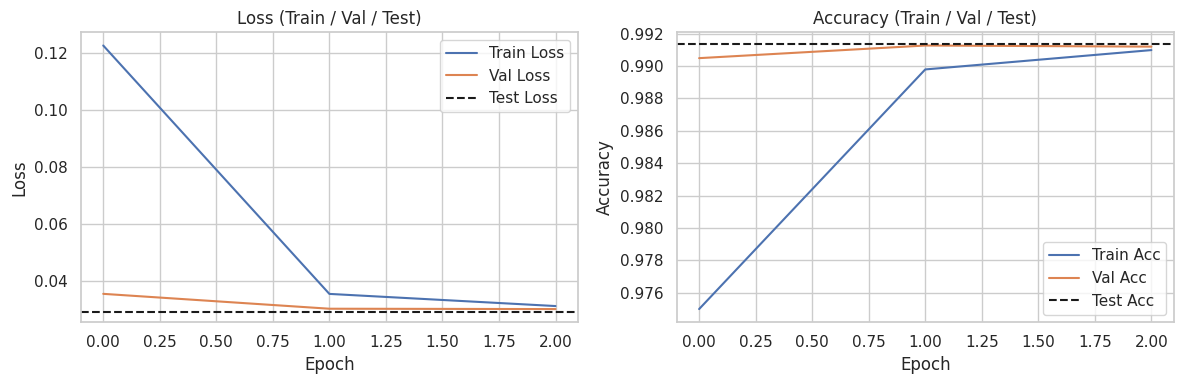

Final metrics -> {'train_loss': 0.031086103310187657, 'val_loss': 0.030024938997626305, 'test_loss': 0.02913537539243698, 'train_acc': 0.9909916666666667, 'val_acc': 0.99120625, 'test_acc': 0.99139375}


In [9]:
# Train/Val/Test curves with proper labels
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].axhline(test_loss, color='k', linestyle='--', label='Test Loss')
axes[0].set_title('Loss (Train / Val / Test)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='best')

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc')
axes[1].plot(history['val_acc'], label='Val Acc')
axes[1].axhline(test_acc, color='k', linestyle='--', label='Test Acc')
axes[1].set_title('Accuracy (Train / Val / Test)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

print('Final metrics ->', {
    'train_loss': history['train_loss'][-1],
    'val_loss': history['val_loss'][-1],
    'test_loss': test_loss,
    'train_acc': history['train_acc'][-1],
    'val_acc': history['val_acc'][-1],
    'test_acc': test_acc,
})
